In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [ ]:
img_dir = "/DataSet/Medical mask/Medical mask/Medical Mask/images"
train_full = pd.read_csv("/DataSet/train.csv")
test_full = pd.read_csv("/DataSet/test.csv")

In [ ]:
train_full.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


# Create new datasets

In [ ]:
options = ['face_with_mask','face_no_mask']
train = train_full[train_full['classname'].isin(options)].sort_values('name')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# encode classname column since it has inly to classes
train['target'] = le.fit_transform(train.classname)
print("Number of unique images in train set: ", train.name.nunique())
train.head()

Number of unique images in train set:  3390


,name,x1,x2,y1,y2,classname,target
13381,1801.jpg,451,186,895,697,face_no_mask,0
3463,1802.jpg,110,71,273,272,face_with_mask,1
14835,1803.jpg,126,75,303,333,face_with_mask,1
5867,1804.jpg,112,113,262,307,face_with_mask,1
6194,1805.jpg,728,180,853,336,face_with_mask,1


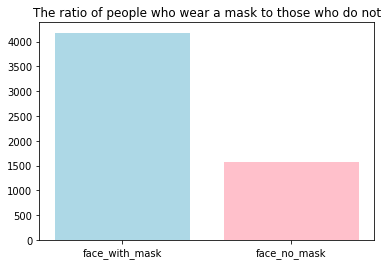

In [ ]:
plt.bar(['face_with_mask','face_no_mask'], train.classname.value_counts(), color = ['lightblue','pink']);
plt.title('The ratio of people who wear a mask to those who do not');

In [ ]:
train_images = train.name.unique().tolist()
test_images = test_full.name.unique().tolist()

**Sample image from train set**

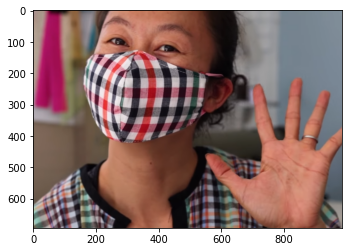

In [ ]:
# pick a random index from train_images
i = np.random.choice(np.arange(1801, len(train_images)))
# read image
img = plt.imread(os.path.join(img_dir,train_images[i]))
# plot image
plt.imshow(img)

**Sample image from test set**

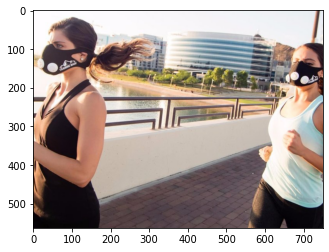

In [ ]:
# pick a random index from test_images
i = np.random.choice(len(test_images))
# read image
img = plt.imread(os.path.join(img_dir,test_images[i]))
# plot image
plt.imshow(img)

In [ ]:
# create a list that would contain bounding boxes for each face
bounding_box=[]
for i in range(len(train)):
    lst = []
    # extract coordinates of bounding box
    for box in train.iloc[i][["x1",'x2','y1','y2']]:
        lst.append(box)
    bounding_box.append(lst)
    
#add new column with bounding boxes
train["bounding_box"] = bounding_box  

# get box(es) for each unique image
def get_boxes(filename):
    boxes = []
    # get bounding_box column for all rows where train["name"] == filename
    for box in train[train["name"] == filename]["bounding_box"]:
        boxes.append(box)
    return boxes

[[43, 138, 284, 374], [331, 150, 538, 462]]


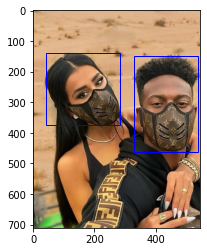

In [ ]:
# draw an image with detected objects
def draw_facebox(image, boxes):
    # plot the image
    plt.imshow(image)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for box in boxes:
    # get coordinates
        x1, y1, x2, y2 = box[0], box[1], box[2], box[3],
        # create the shape
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                             fill=False, color='b', linewidth=1)
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()
    
# pick a random index from train_images
i = np.random.choice(np.arange(1801, len(train_images)))
# read image
image = plt.imread(os.path.join(img_dir,train_images[i]))
# get boxes for image
boxes = get_boxes(train_images[i])
print(boxes)
draw_facebox(image, boxes)

# Create training data

In [ ]:
img_size=128
data=[]
for i in range(len(train)):
    x1,y1,x2,y2 = train.iloc[i]['bounding_box']
    image = train.iloc[i]['name']
    # read image with green channel
    img_array = cv2.imread(os.path.join(img_dir,image), 1)
    # crop image with bounding box
    img_cropped = img_array[y1:y2,x1:x2] 
    # resize cropped image
    img = cv2.resize(img_cropped,(img_size,img_size))
    data.append([img,train.iloc[i]['target']])

In [ ]:
# X is list of all images
# Y is list of corresponding target values

X=[]
Y=[]
# Features are cropped images
# Labels are target values
for features, labels in data:
    X.append(features)
    Y.append(labels)
# Normalising the Training data
X = np.array(X)/255
print('Shape of X:', X.shape)
Y = np.array(Y)
print('Shape of Y:', Y.shape)

Shape of X: (5749, 128, 128, 3)
Shape of Y: (5749,)


# Build and fit the model

In [ ]:
# build the model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=5, activation="relu", padding='same', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0

In [ ]:
from sklearn.model_selection import train_test_split
# split our data into train and validation sets
X_train,X_val,y_train,y_val = train_test_split(X, Y,train_size=0.8,random_state=0)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
              loss='binary_crossentropy', metrics=['accuracy']) 
# fit the model
history = model.fit(X_train,y_train,batch_size=32,
                    epochs=40,
                    validation_data=(X_val, y_val))

Epoch 1/40
144/144 [==============================] - 167s 1s/step - loss: 0.5397 - accuracy: 0.7344 - val_loss: 0.3039 - val_accuracy: 0.8930
Epoch 2/40
144/144 [==============================] - 165s 1s/step - loss: 0.2992 - accuracy: 0.8863 - val_loss: 0.2699 - val_accuracy: 0.8957
Epoch 3/40
144/144 [==============================] - 166s 1s/step - loss: 0.2711 - accuracy: 0.8926 - val_loss: 0.2522 - val_accuracy: 0.9104
Epoch 4/40
144/144 [==============================] - 166s 1s/step - loss: 0.2496 - accuracy: 0.8902 - val_loss: 0.2545 - val_accuracy: 0.9009
Epoch 5/40
144/144 [==============================] - 167s 1s/step - loss: 0.2375 - accuracy: 0.9020 - val_loss: 0.2530 - val_accuracy: 0.8939
Epoch 6/40
144/144 [==============================] - 165s 1s/step - loss: 0.2181 - accuracy: 0.9127 - val_loss: 0.2205 - val_accuracy: 0.9139
Epoch 7/40
144/144 [==============================] - 165s 1s/step - loss: 0.2140 - accuracy: 0.9137 - val_loss: 0.2257 - val_accuracy: 0.9113

Text(0.5, 0, 'Epoch')

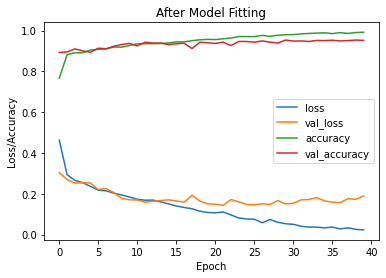

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()
plt.title('After Model Fitting')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
